# Task 3: Try Unet

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel



Start simple with provided segmentation models from pytorch
https://github.com/qubvel/segmentation_models.pytorch

also https://amaarora.github.io/2020/09/13/unet.html
and https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb

https://www.pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [1]:
from task3.utils.utils import init
from task3.utils.config import get_data_loader, get_optimizer, get_model
from task3.utils.data_utils import evaluate
from task3.utils.img_utils import show_img_batch
import importlib
import sys
import time

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import segmentation_models_pytorch as smp
from torchmetrics import IoU
from torch.nn import BCEWithLogitsLoss

# Image datasets and image manipulation
import torchvision

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## Params

In [2]:
config = init(config='configs/raphaela.yaml')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


## Define Model

In [4]:
config['model'].get('smp-unet')

{'encoder_name': 'resnet34',
 'encoder_weights': None,
 'in_channels': 1,
 'classes': 2,
 'encoder_depth': 5,
 'decoder_use_batchnorm': True,
 'decoder_channels': [256, 128, 64, 32, 16],
 'decoder_attention_type': None,
 'activation': 'sigmoid',
 'aux_params': None}

In [5]:
model = smp.Unet(**config['model'].get('smp-unet')).to(device)

## Load data

In [6]:
training_loader, validation_loader = get_data_loader(config, mode='train', get_subset=False)
# TODO fix error key
# test_loader = get_data_loader(config, mode='test', get_subset=False)

2021-12-19T12:41:03.650150+0000 DEBUG Exclude samples: None, include samples: None, applied transforms: Compose(
    ToTensor()
)
2021-12-19T12:41:12.309960+0000 DEBUG Loaded samples: ['DY7ASN54S9', 'GC4N2W3CPZ', 'T8KF3Q2B2F', 'DTKPN7XP6M', 'K3AM1YOI38', 'QPQSQTSI7D', 'D29HWPRZUW', 'QFGAOZX5JI', 'RC4B5W3ATB', '8G7XRFIWB3', 'LDBF4IFZ6H', 'AYPVNPO9R0', 'ZSLPMQEWOY', 'FIW33CVMV0', 'IJZFZ2P3UT', '7V9NY3JFPX', 'YTEBHX6SH5', '5NJTVZ6ZOJ', '7IBG80WR2T', 'VVCUF1AI87', 'R5OV0RKYDG', 'YSCCEISFRH', 'MW16WM2HPQ', '1D7PVKV2AP', '8AHY2IWS17', '4XBC2X5ZTR', 'D47OR19ANJ', 'T2LZGPQNQI', 'VI47TJR3OQ', 'GF7SRBBU1E', '2O92K3GBLM', '0S1GBHENTP', 'M1FI0BAOWB', 'O26IJHI6MH', 'IJN60PIITZ', 'XBTT6NEY4T', 'D8I212VOCH', '6I8D4BKPUE', 'IMNKTJV3OI', 'GFOJ0HGKZH', 'YF6QEAWJXY', 'DMKG04F0SB', 'BBB0U709D2', 'C6WKLGHUIM', '3YLPDRY0FA', '4W4P3UREMQ', '11NZLRCO13', 'QZA3WA0E2X', 'R82Q2AL9P7', '1XHV0Q88M5', 'E9AHVWGBUF', 'WO0OOZLXP6', 'ZMJIDN442P', 'OYZFKJR8U3', '3DGDHONGJW', 'YEZ7BPLZW0', 'W00G0Q112W', 'JANFS05F33', 'ON

In [7]:
batch = next(iter(training_loader))

In [8]:
batch_valid = next(iter(validation_loader))

In [9]:
batch['id']

['JANFS05F33_11',
 'YEZ7BPLZW0_34',
 'QPQSQTSI7D_145',
 'W00G0Q112W_73',
 'BBB0U709D2_121',
 'T2LZGPQNQI_36',
 'OYZFKJR8U3_48',
 'BBB0U709D2_16',
 'E9AHVWGBUF_6',
 'FIW33CVMV0_49']

In [10]:
batch_valid['id']

['4XBC2X5ZTR_47',
 'D29HWPRZUW_83',
 'QPQSQTSI7D_67',
 'H7G0BX4HFV_28',
 'T2LZGPQNQI_101',
 '1D7PVKV2AP_0',
 'GFOJ0HGKZH_0',
 '0S1GBHENTP_15',
 'RC4B5W3ATB_0',
 'O26IJHI6MH_183']

## Optimizer & Loss

Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model.

https://pytorch.org/docs/stable/optim.html

In [ ]:
# use config file
# get_model(config)
# optimizer = get_optimizer(model, config)
# criterion = get_loss(config)

In [11]:
#optimizer = config['training']['optimizer']
#lr = config['training']['lr']
#momentum = config['training']['momentum']
#loss = config['training']['loss']
#num_classes = config['training'].get('get_classes', 2)
#
#if optimizer == 'Adam':
#    
#elif optimizer == 'SGD':
#    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#else:
#    raise Exception('Optimizer not supported, choose among Adam and SGD.')
#
##if loss == 'iou':
#    criterion = IoU(num_classes=num_classes)
#
#elif loss == 'bcewithlogits':
#    assert config['model']['smp-unet']['activation'] == None, f'Last layer of the Unet model should not be sigmoid \
#    if you are using {loss}.'
#    # Sigmoid + BCELoss, numerically more stable 
#    criterion = BCEWithLogitsLoss(pos_weight=None) 
#

optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss = smp.utils.losses.DiceLoss()    
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

## Show images on Tensorboard

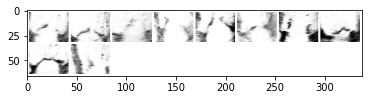

In [14]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
batch = dataiter.next()
images, labels = batch['frame_cropped'], batch['label_cropped']

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)


# Default log_dir argument is 'runs' - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/mv_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Batch Images MV', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

## Training loop

In [17]:
print(len(training_loader))
num_epochs = config['training']['epochs']
data_iter = iter(training_loader)

print("[INFO] training the network...")
startTime = time.time()

for epoch in range(num_epochs):  # loop over the dataset multiple times, start with one single epoch
    print(f'epoch {epoch} / {num_epochs}')
    running_loss = 0.0
    
    # TODO model.train() # dropout, batchnorm behave differently if train vs eval
        
    for i, batch in enumerate(training_loader):
        # basic training loop
        
        # conv expectes (n_samples, channels, height, width) # e.g., (1000, 1, 224, 224)
        # Passing grayscale images in their usual format (224, 224) won't work.
        # Need to add one channel dimension
        # https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but
        inputs, labels = batch['frame_cropped'], batch['label_cropped'] 
        optimizer.zero_grad(set_to_none=False)
        
        # does model have flatten layer?
        # Flatten images into a xxx long vector
        #inputs = inputs.view(inputs.shape[0], -1)
        
        print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            model.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            model.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 100
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

16
[INFO] training the network...
epoch 0 / 1
torch.Size([10, 1, 30, 40])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 3 for tensor number 1 in the list.

In [36]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:


from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)